# Sheer Heart Attack
### By: Jordan Crawford-O'Banner

Heart disease is the number one cause of death worldwide. As such, Driven Data has proposed a challenged to use a specific dataset from the Cleveland Heart Disease Database to try and create a machine learning model that can predict if a person has heart disease based upon certain factors. The data has 13 different health factors that are linked to heart disease. This is a classification problem because the goal is to determine only if they have heart disease or not. There are a few approaches to the problem that can be taking by using machine learning. This notebook will compare a few of those approaches.

The two approaches that we will be taking are by comparing a simple regression model and a deep learning model. Each of these approaches has their advantages and their disadvantages. The simple regression model has a lot of parts that can be analyzed in detail. The different parameters within the model can be tuned, and it is easy to test its accuracy. The deep learning model on the other hand, tend to be more accurate when they are done correctly. However, they can only be changed from the surface, and it can be very difficult to identify the inner workings of their algorithms.

First the necessary libraries and functions are imported.

In [1]:
import jax.numpy as np
from jax import jit
import numpy.random as npr

import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import thinkstats2
import pandas as pd

from jax import grad

import jax
from tqdm import tqdm_notebook as tqdmn

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Here the file that contains the necessary data is loaded into the notebook.. The indicators for heart disease are initially represented by 1 and 2. In order to more effectively build a model, they are switched so that 0 indicates not having heart disease, and 1 indicates having heart disease.

In [2]:
data = pd.read_csv("./heartdata.csv")
data['heart_disease'].replace(1, 0, inplace=True)
data['heart_disease'].replace(2, 1, inplace=True)

The data shown below contains thirteen explanatory variables and one target variable. The variables include the age and sex of the respondent. The data corresponds people who are as male to 0 and people who are female to 1. There is also chest pain, which is recorded on a scale from 1 to 4. Other variables include resting blood pressure, serum cholestoral, if fasting blood pressure is greater 120 mg/dl , resting electrocardiograph results, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment,  number of major vessels colored by flourosopy, and the status of the respondents thalamus. It is important to note that exercise induced angina, sex, and fasting blood pressure are all binary values, and the status of the respondents thalamus is a nominal value.

In [3]:
data.head()

,age,sex,chest_pain,rest_bp,serum_chol,fast_bs,rest_ecg,max_heart_rate,exercise_angina,oldpeak,peak_slope,flourosopy_vessels,thal,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


To increase the accuracy of the data data, the values that are  not binary or nominal need to be standardized. These values are on very different scales, so when the model attempts to compare them it will under utilize variables with smaller values and over utilize variables with larger values. Next,the data is split into variables and the target or X and y, and those are split into training and test sets so that the model can be evaluated.

In [4]:
bigdata = data
bigdata["age"]=bigdata["age"]/max(bigdata["age"])
bigdata["rest_bp"]=bigdata["rest_bp"]/max(bigdata["rest_bp"])
bigdata["serum_chol"]=bigdata["serum_chol"]/max(bigdata["serum_chol"])
bigdata["max_heart_rate"]=bigdata["max_heart_rate"]/max(bigdata["max_heart_rate"])
bigdata["oldpeak"]=bigdata["oldpeak"]/max(bigdata["oldpeak"])
bigdata["flourosopy_vessels"]=bigdata["flourosopy_vessels"]/max(bigdata["flourosopy_vessels"])
y=pd.DataFrame(data["heart_disease"])
X= bigdata
X=X.drop("heart_disease",axis=1)
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Below, Lasso regression is used to identify the most influential variables within the dataset

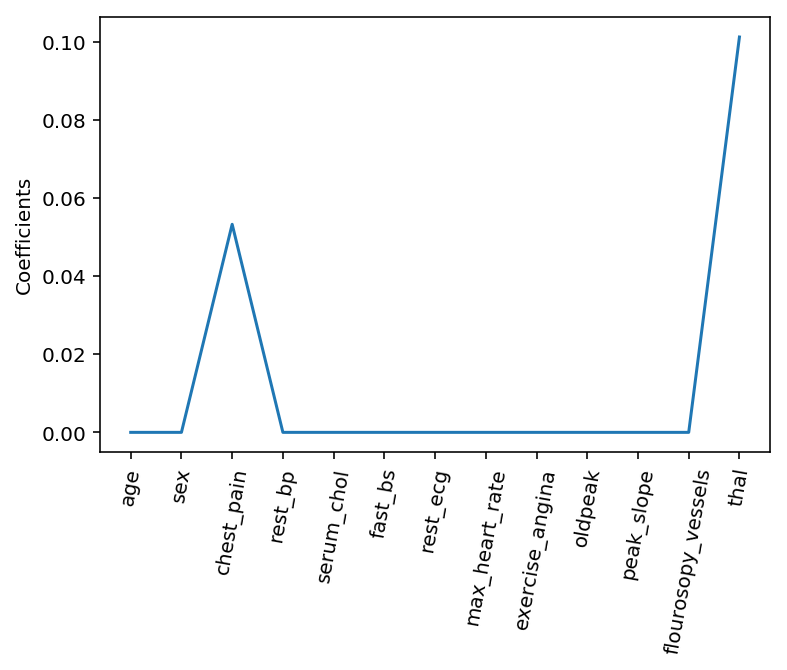

In [5]:
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
names = data.drop('heart_disease', axis=1).columns
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=80)
_ = plt.ylabel('Coefficients')
plt.show()

The graph shows that the most important variables are chest pain and the status of the respondents thalamus. The thalamus is the most influential variable here.

Next a deep learning model will be implemented to predict if a respondent has heart disease. Two hidden layers are used within the model. The first one uses tanh as the activation function. A tanh function is similar to a logistic function, but it keeps values between -1 and 1. This function was chosen because it is similar to a logistic function, which means that it will put the model closer to the answer it is searching for. The second hidden layer uses a logistic function. Both of these through a logistic function and arrive at the answer. The deep learning algorithm uses this model and performs gradient descent on it in order to minimize the loss.

The logistic function is used as a means of performing log on the parameters. The logistic loss function calculates the mean loss between the predicted answer and the actual answer. Noise creates a normal distribution of a specified size. The model function holds the actual deep learning model within it, and it outputs the predicted answers.

In [6]:
def logistic(x):
    return 1 / (1 + np.exp(-x))
    
def logistic_loss(p, model, x, y):
    preds = model(p, x)
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

# Exercise: Define gradient of loss function.
dlogistic_loss = grad(logistic_loss)

def noise(size):
    return npr.normal(size=size)

# Exercise: Initialize parameters
params = dict()
params['w1'] = noise((13,6))
params['b1'] = noise((6,))
params['w2'] = noise((6,3))
params['b2'] = noise((3,))
params['w3'] = noise((3,1))
params['b3'] = noise((1,))

# Exercise: Write model together.
def model(p, x):
    
    a1 = np.tanh(np.dot(x,p['w1'])+p['b1'])
    # "a1" is the activation from layer 1
    
    # "a2" is the activation from layer 2
    a2 = logistic(np.dot(a1,p['w2'])+p['b2'])
    
    a3 = logistic(np.dot(a2,p['w3'])+p['b3'])
    return a3

# We do not need to rewrite the logistic loss: this is because it has been defined above already!

# Exercise: Write training loop.
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X_train.values, y_train.values)
    for k, v in params.items():
        params[k] = params[k] - grad_p[k] * 0.01
    losses.append(logistic_loss(params, model, X_train.values, y_train.values))

A Jupyter Widget

/home/jobanner/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Here I plot the loss over each iteration that the gradient descent is preformed. As you can see the more iterations that are performed, the lower the loss gets until it eventually plateaus. This model reaches a final loss of 0.38.

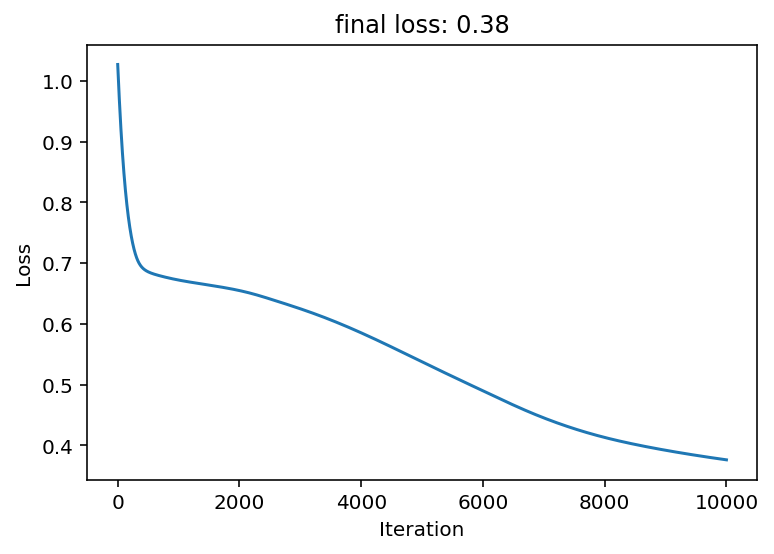

In [7]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()

Now that the model is as accurate as possible, it can be used on the testing set to see how accurate it is. Shown below is the confusion matrix and a heat map to show the confusion matrix in a more visual basis.

[[43  6]
 [ 8 24]]


Text(33,0.5,'actual')

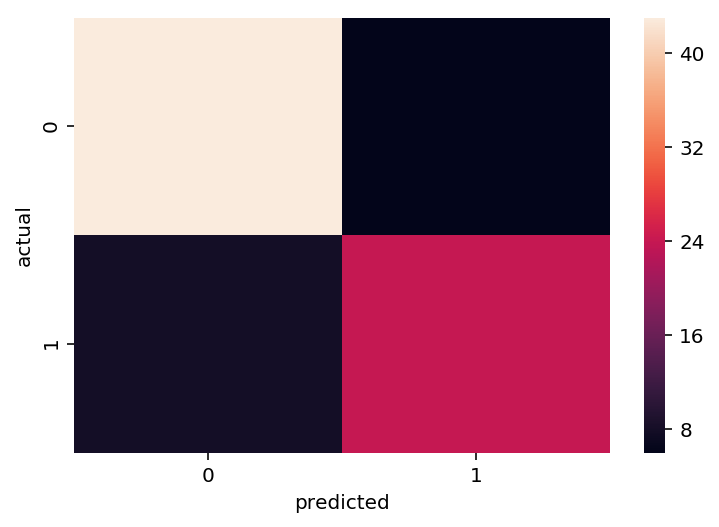

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model(params, X_test.values)
print(confusion_matrix(y_test, np.round(y_pred)))
sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

The confusion matrix shows that a majority of the prediction correctly chose whether or not a respondent had heart disease or not. Although this model is very accurate, it is very useful to look at other deep learning models that have differing numbers of hidden layers or different activation functions to ensure the chosen model is actually the most accurate model.Unlike the previous model, the model below only uses one hidden layer, which uses logarithm as an activation function. 

A Jupyter Widget

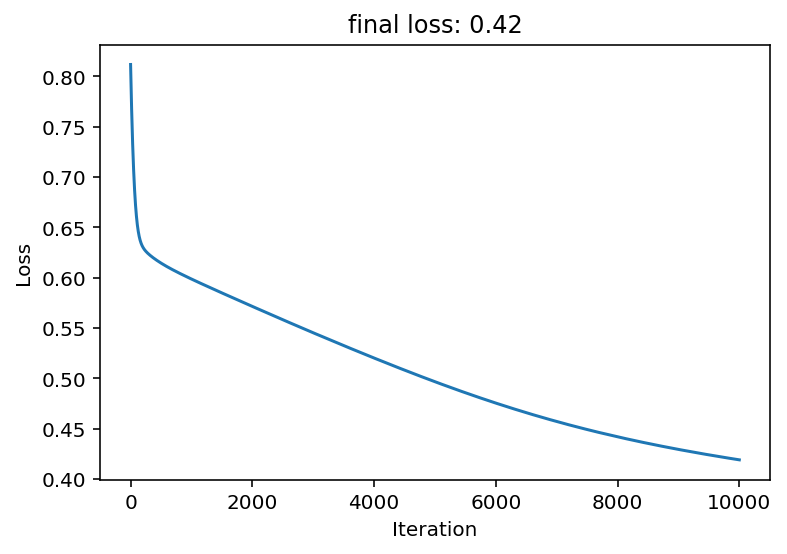

In [9]:
# Exercise: Initialize parameters
params = dict()
params['w1'] = noise((13,6))
params['b1'] = noise((6,))
params['w2'] = noise((6,1))
params['b2'] = noise((1,))

# Exercise: Write model together.
def model(p, x):
    
    a1 = logistic(np.dot(x,p['w1'])+p['b1'])
    # "a1" is the activation from layer 1
    
    # "a2" is the activation from layer 2
    a2 = logistic(np.dot(a1,p['w2'])+p['b2'])
    
    return a2

# We do not need to rewrite the logistic loss: this is because it has been defined above already!

# Exercise: Write training loop.
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X_train.values, y_train.values)
    for k, v in params.items():
        params[k] = params[k] - grad_p[k] * 0.01
    losses.append(logistic_loss(params, model, X_train.values, y_train.values))
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()

This model has a final loss of 0.44, which is higher than the previous model. The model should therefore preform worse in the prediction test than the model last model.

[[45  4]
 [ 8 24]]


Text(33,0.5,'actual')

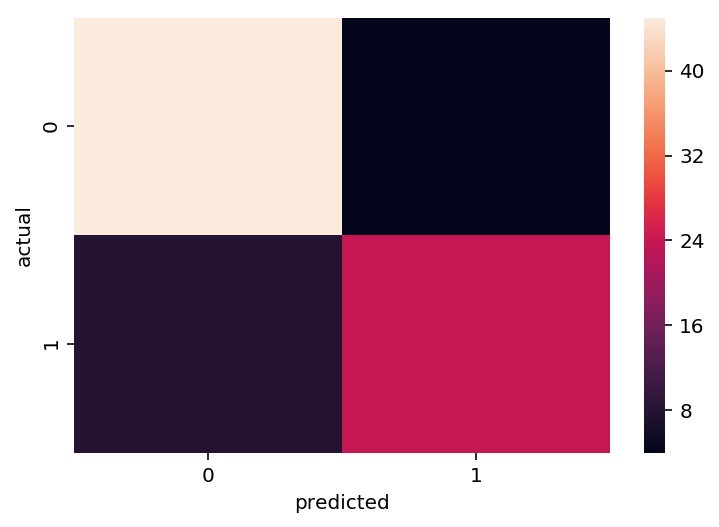

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model(params, X_test.values)
print(confusion_matrix(y_test, np.round(y_pred)))
sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

This model does not correctly predict heart disease for as many respondents as the last model, which was expected. To ensure that all options are exhausted, we will run one more model. The next model has two hidden layers. This one uses logistic for the first layer and a relu activation function for the second layer.

A Jupyter Widget

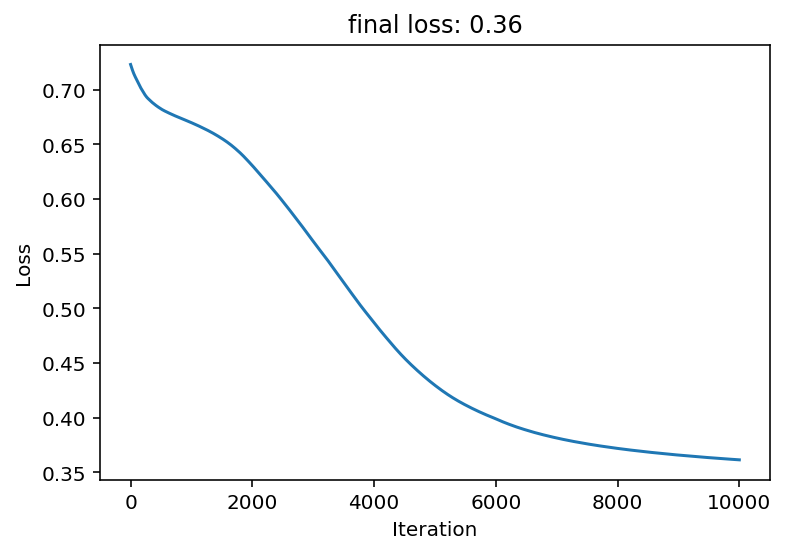

In [11]:
# Exercise: Initialize parameters
params = dict()
params['w1'] = noise((13,6))
params['b1'] = noise((6,))
params['w2'] = noise((6,3))
params['b2'] = noise((3,))
params['w3'] = noise((3,1))
params['b3'] = noise((1,))

def relu(x):
    return np.maximum(x, 0)

# Exercise: Write model together.
def model(p, x):
    
    a1 = logistic(np.dot(x,p['w1'])+p['b1'])
    # "a1" is the activation from layer 1
    
    # "a2" is the activation from layer 2
    a2 = relu(np.dot(a1,p['w2'])+p['b2'])
    
    
    a3 = logistic(np.dot(a2,p['w3'])+p['b3'])
    return a3

# We do not need to rewrite the logistic loss: this is because it has been defined above already!

# Exercise: Write training loop.
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X_train.values, y_train.values)
    for k, v in params.items():
        params[k] = params[k] - grad_p[k] * 0.01
    losses.append(logistic_loss(params, model, X_train.values, y_train.values))
plt.plot(losses)
plt.title(f"final loss: {losses[-1]:.2f}")
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

This model has the lowest loss yet with only 0.37. This one should preform the best out of any of the models that have been created so far.

[[44  5]
 [ 8 24]]


Text(33,0.5,'actual')

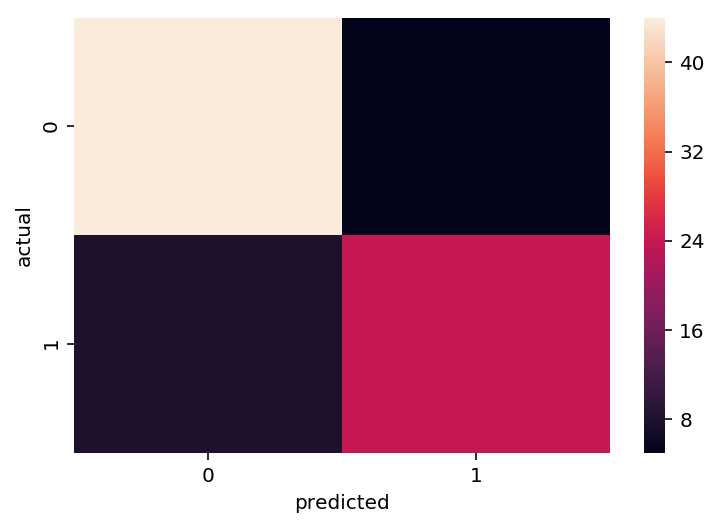

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model(params, X_test.values)
print(confusion_matrix(y_test, np.round(y_pred)))
sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

This has the highest number of correct predictions out of all the models. However, it is not much better than the first model.

Now I will use the logistic regression model. Here I instantiate a logistic regression object and fit it to my training data. By doing this, I create a model that should accurately predict the testing data.

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)
logreg.score(X_test,y_test)

/home/jobanner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jobanner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8765432098765432

The score shown there shows that the model predicted about 87% of the testing data correctly. Here is a confusion matrix in order to compare it to the deep learning model.

[[47  2]
 [ 8 24]]


Text(33,0.5,'actual')

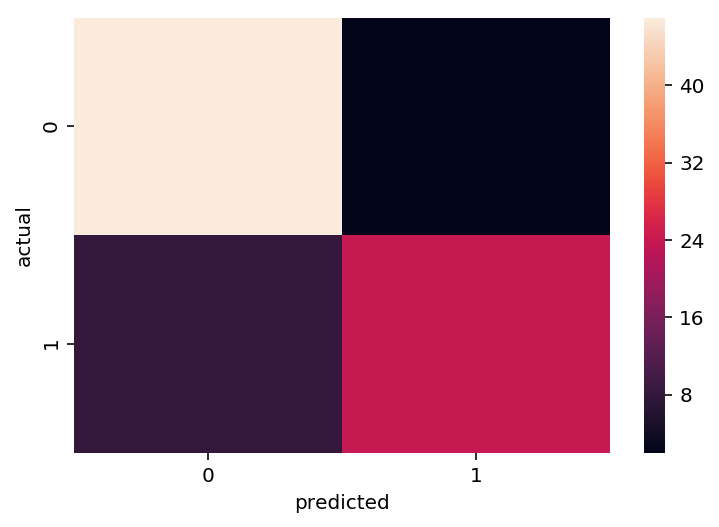

In [14]:
print(confusion_matrix(y_test, np.round(y_pred)))
sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

The confusion matrix for this model can be seen to preform better than any of the deep learning model, but it does not do that much better than the best deep learning model. The logistic regression model has both more true positives and also less fewer wrong predictions.

Next to further analyze the logistic regression model, I will plot a roc curve. The area under this curve shows the true positive rate of my model.

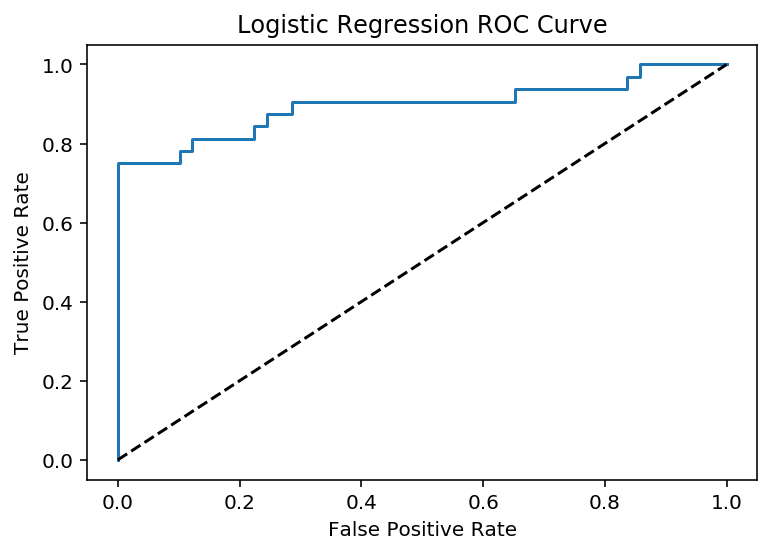

0.8960459183673469

In [15]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();
roc_auc_score(y_test,y_pred_prob)

The model has about a 90% true positive rate, which is very good.

## Conclusion

The three deep learning models that were implemented all did only slightly worse than the logistic regression model. None of the models were outstandingly better than the others, and therefore ,on the basis of performance, there is not a specific reason to choose one model over another unless the slight increase in accuracy is very important. However, on the basis of efficiency the logistic regression model is the best. The deep learning models required ten thousand iterations to be as accurate as they got, which cost lots of computing power and time. Whereas the logistic regression model takes almost no time at all and is calculated rather easily. Also, getting to the deep learning model with the best performance took three tries and barely proved to obtain results that were worth the amount of tuning. In the end, a simple logistic regression model may be best for this competition because there is less overhead in getting an accurate model.